In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd

In [2]:
import numpy as np
import glob
import re
from collections import defaultdict

# Helper function to extract tau value from filename
def extract_tau(filename):
    match = re.search(r"tau=([\d.eE+-]+)", filename)
    return float(match.group(1)) if match else None

# Find all relevant .npy files
files = glob.glob("learning/field*_tau=*.npy")

# Initialize nested dictionary
data = defaultdict(dict)

for f in files:
    tau = extract_tau(f)
    # Remove path and extension
    base = f.split('/')[-1].replace('.npy', '')
    # Example base: field_training_af_tau=123.4
    parts = base.split('_tau=')[0].split('_')  # e.g., ['field', 'training', 'af']
    
    # Join everything after 'field' to form key names
    # field_type: e.g., 'training', 'perturb', or '' (for plain field)
    # state: 'bf' or 'af'
    if len(parts) == 2:
        field_type, state = '', parts[1]
    else:
        field_type, state = parts[1], parts[-1]

    # Build key like: data['training']['bf']
    field_key = field_type if field_type else 'base'
    data[field_key][state] = {
        "tau": tau,
        "field": np.load(f)
    }

# Convert defaultdict to normal dict for neatness
data = {k: dict(v) for k, v in data.items()}

In [3]:
df = pd.read_csv('learning/learning_perturb.csv', index_col=0)

Figure

vmin=np.float64(7.804219067999037) vmax=np.float64(11.839835213894911)


/tmp/ipykernel_94093/818377769.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


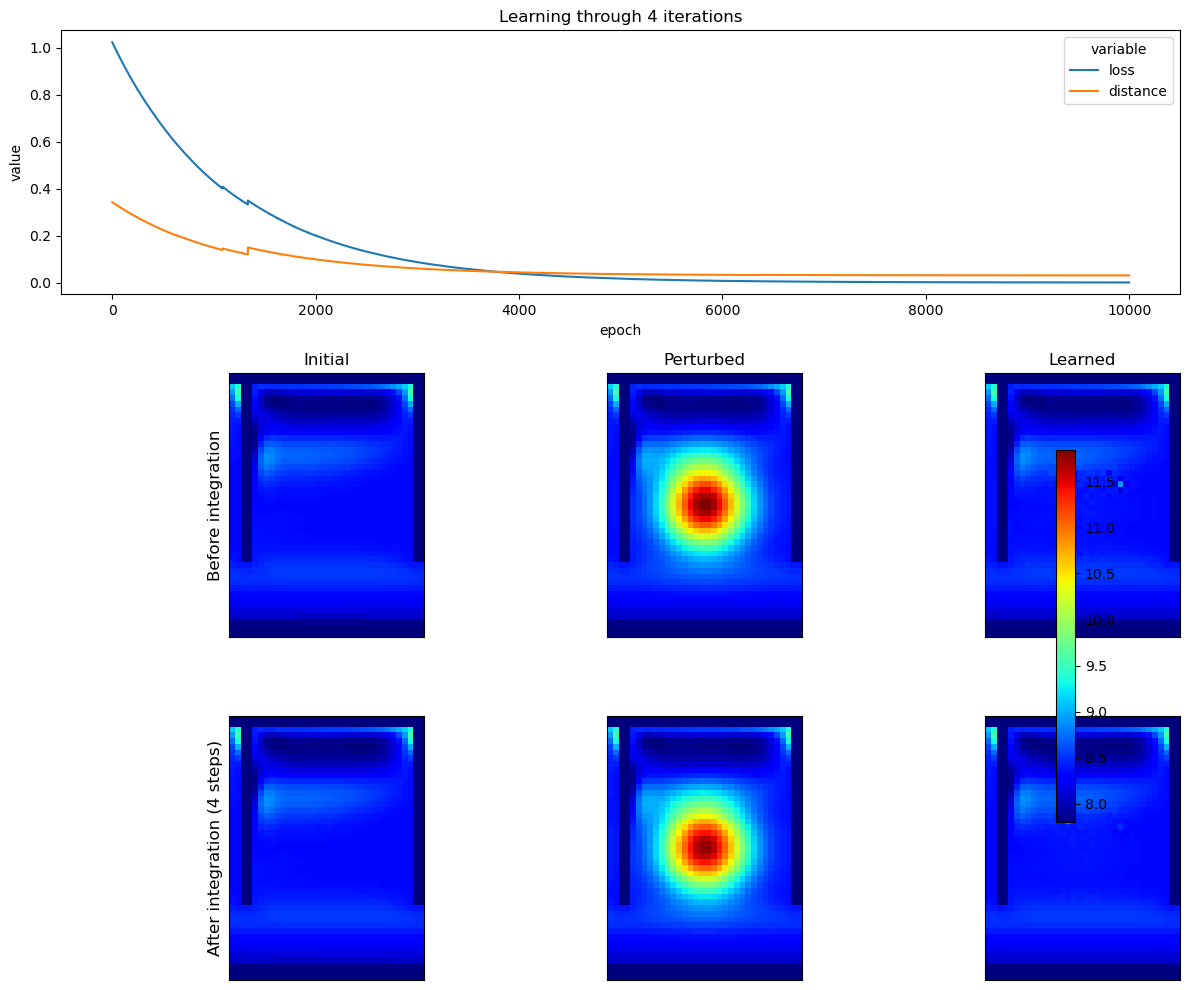

In [10]:

def tau_to_index(tau, tol=1e-6):
    """Convert a stored tau (float/int) to an integer index for slicing.
    If tau is None -> raises ValueError.
    If tau is integer-like within tol -> returns int(round(tau)).
    Otherwise rounds to nearest int and warns.
    """
    if tau is None:
        raise ValueError("tau is None; cannot index time axis.")
    # handle numpy scalars
    try:
        tau_val = float(tau)
    except Exception:
        raise ValueError(f"Cannot convert tau {tau!r} to float.")
    nearest = int(round(tau_val))
    if abs(tau_val - nearest) <= tol:
        return nearest
    warnings.warn(
        f"tau={tau_val} is not integer-like; rounding to index {nearest}. "
        "If tau represents a continuous time you may need a mapping to the time-index.",
        UserWarning
    )
    return nearest

# --- Parameters ---
vl = 5  # vertical level
# ensure n_iteration and df are defined in your namespace
# n_iteration = ...
# df = ...

fig = plt.figure(figsize=(12, 10))
gs = GridSpec(3, 3, figure=fig)

# --- Top: line plot ---
ax_top = fig.add_subplot(gs[0, :])
sns.lineplot(data=df.melt(id_vars='epoch'), x='epoch', y='value', hue='variable', ax=ax_top)
ax_top.set_title(f'Learning through {4} iterations')

# --- Shared color scale (using perturb before tau index exactly as original) ---
tau_ref_idx = tau_to_index(data['perturb']['bf']['tau'])

vals = data['perturb']['bf']['field'][..., vl, tau_ref_idx].flatten()
vmin = vals[vals != 0].min()
vmax = vals[vals != 0].max()
print(f'{vmin=} {vmax=}')


# --- Prepare 3×2 image axes (rows: before/after, columns: base, perturb, training) ---
ax_imgs = [[fig.add_subplot(gs[1, i]) for i in range(3)],
           [fig.add_subplot(gs[2, i]) for i in range(3)]]

# store AxisImage objects so we can reference them for the colorbar
images = [[None]*3 for _ in range(2)]

titles = ["Initial", "Perturbed", "Learned"]
field_keys = ['base', 'perturb', 'training']

# --- Plot image rows with correct tau indexing ---
for row_idx, state in enumerate(['bf', 'af']):            # 0: before, 1: after
    for col_idx, key in enumerate(field_keys):            # columns
        ax = ax_imgs[row_idx][col_idx]
        try:
            entry = data[key][state]
        except KeyError:
            # if a particular key/state missing, switch axis off
            ax.axis('off')
            continue

        tau_idx = tau_to_index(entry.get('tau', None))
        img = entry['field'][..., vl, tau_idx].T
        images[row_idx][col_idx] = ax.imshow(img, vmin=vmin, vmax=vmax, cmap='jet')
        ax.invert_yaxis()
        if row_idx == 0:
            ax.set_title(titles[col_idx])
        ax.set_xticks([])
        ax.set_yticks([])

# --- Row labels ---
ax_imgs[0][0].set_ylabel("Before integration", fontsize=12)
ax_imgs[1][0].set_ylabel(f"After integration ({4} steps)", fontsize=12)

# --- Shared colorbar (use the middle top image as reference if available) ---
mappable = images[0][1] or images[0][0]  # prefer perturb top middle; fallback to first top-left
if mappable is not None:
    fig.colorbar(mappable, ax=[a for row in ax_imgs for a in row if a is not None],
                 orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()

/tmp/ipykernel_94093/108076902.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


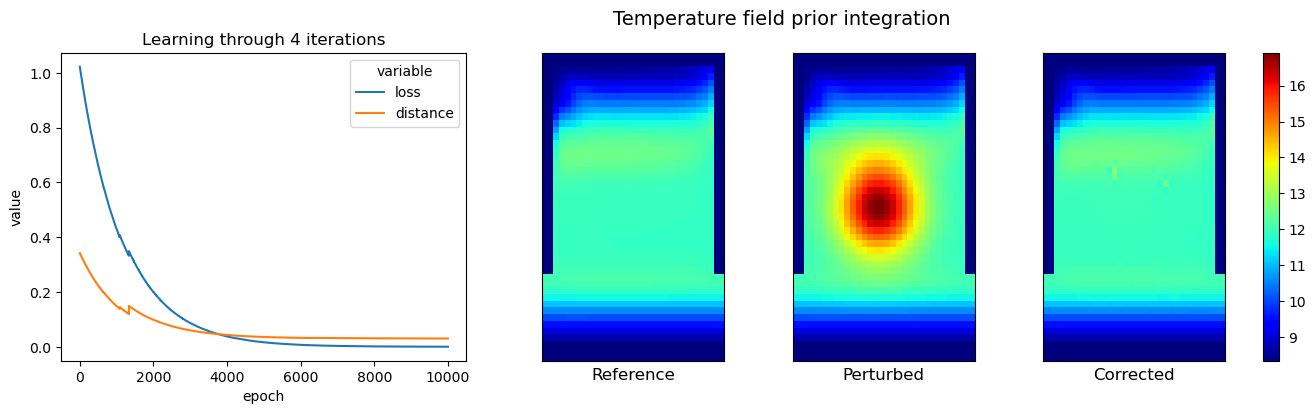

In [37]:

# --- Parameters ---
vl = 8
n_iteration = 4  # example
# df = ...  # your learning curve dataframe
# --- Layout: 1 row, 4 columns, all same height ---
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4, figure=fig, width_ratios=[2, 1, 1, 1], hspace=0.0, wspace=0.3)


# --- Left: line plot ---
ax_line = fig.add_subplot(gs[0, 0])
sns.lineplot(data=df.melt(id_vars='epoch'), x='epoch', y='value', hue='variable', ax=ax_line)
ax_line.set_title(f'Learning through {n_iteration} iterations')

# --- Right: 3 images for bf states ---
field_keys = ['base', 'perturb', 'training']
image_labels = ["Reference", "Perturbed", "Corrected"]
images = []

# shared color scale using perturb bf
tau_ref_idx = tau_to_index(data['perturb']['bf']['tau'])
vals = data['perturb']['bf']['field'][..., vl, tau_ref_idx].flatten()
vmin = vals[vals != 0].min()
vmax = vals[vals != 0].max()

c = 2
for i, key in enumerate(field_keys):
    ax = fig.add_subplot(gs[0, i+1])
    entry = data[key]['bf']
    tau_idx = tau_to_index(entry['tau'])
    img = entry['field'][c:, :, vl, tau_idx].T
    im = ax.imshow(img, vmin=vmin, vmax=vmax, cmap='jet', aspect='auto')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Label below image
    ax.set_xlabel(image_labels[i], fontsize=12, labelpad=5)
    images.append(im)

# --- Suptitle above the three images ---
fig.text(0.575, 0.95, "Temperature field prior integration", ha='center', fontsize=14)

# --- Shared colorbar ---
fig.colorbar(images[1], ax=[fig.axes[j] for j in range(1, 4)],
             orientation='vertical', fraction=0.05, pad=0.05)

plt.tight_layout()
plt.show()
fig.savefig(f'figures/learning_figure_4iter_{datetime.now().strftime("%d%m%y")}.png')

In [35]:
from datetime import datetime